<a href="https://colab.research.google.com/github/Gousepasha789/Tea-Leaf-disease-detection/blob/main/Plant_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# Step 1: Import required libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# Step 2: Define dataset path
base_path = "/content/drive/MyDrive/teaLeafBD"

# Enhanced image parameters for better accuracy
IMAGE_SIZE = (128, 128)   # Keep this size for faster training
BATCH_SIZE = 32           # Good balance for memory and training

print(f"🖼️ Image Size        : {IMAGE_SIZE}")
print(f"📦 Batch Size        : {BATCH_SIZE}")

🖼️ Image Size        : (128, 128)
📦 Batch Size        : 32


In [25]:
# Step 3: Data Generators with Optimized Augmentation

# Training data with balanced augmentation (less aggressive for better accuracy)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,           # Reduced from 30
    width_shift_range=0.2,       # Reduced from 0.3
    height_shift_range=0.2,      # Reduced from 0.3
    zoom_range=0.2,              # Reduced from 0.3
    shear_range=0.15,            # Reduced from 0.2
    horizontal_flip=True,
    fill_mode='nearest',         # Added for better edge handling
    brightness_range=[0.8, 1.2]  # Less aggressive brightness change
)

# Validation data (NO augmentation, only rescale)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Load training data
train_data = train_datagen.flow_from_directory(
    base_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Load validation data
val_data = val_datagen.flow_from_directory(
    base_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

print("\n✅ Dataset Loaded Successfully!")
print(f"🔹 Training samples   : {train_data.samples}")
print(f"🔹 Validation samples : {val_data.samples}")
print(f"🔹 Number of Classes  : {train_data.num_classes}")
print("🔹 Classes:", list(train_data.class_indices.keys()))

Found 4223 images belonging to 7 classes.
Found 1053 images belonging to 7 classes.

✅ Dataset Loaded Successfully!
🔹 Training samples   : 4223
🔹 Validation samples : 1053
🔹 Number of Classes  : 7
🔹 Classes: ['1. Tea algal leaf spot', '2. Brown Blight', '3. Gray Blight', '4. Helopeltis', '5. Red spider', '6. Green mirid bug', '7. Healthy leaf']



✅ Class Labels Mapping:
   0 → 1. Tea algal leaf spot
   1 → 2. Brown Blight
   2 → 3. Gray Blight
   3 → 4. Helopeltis
   4 → 5. Red spider
   5 → 6. Green mirid bug
   6 → 7. Healthy leaf

📊 Dataset Analysis:
🔹 Total Training Samples: 4223
🔹 Total Validation Samples: 1053
🔹 Samples per class (approx): 603


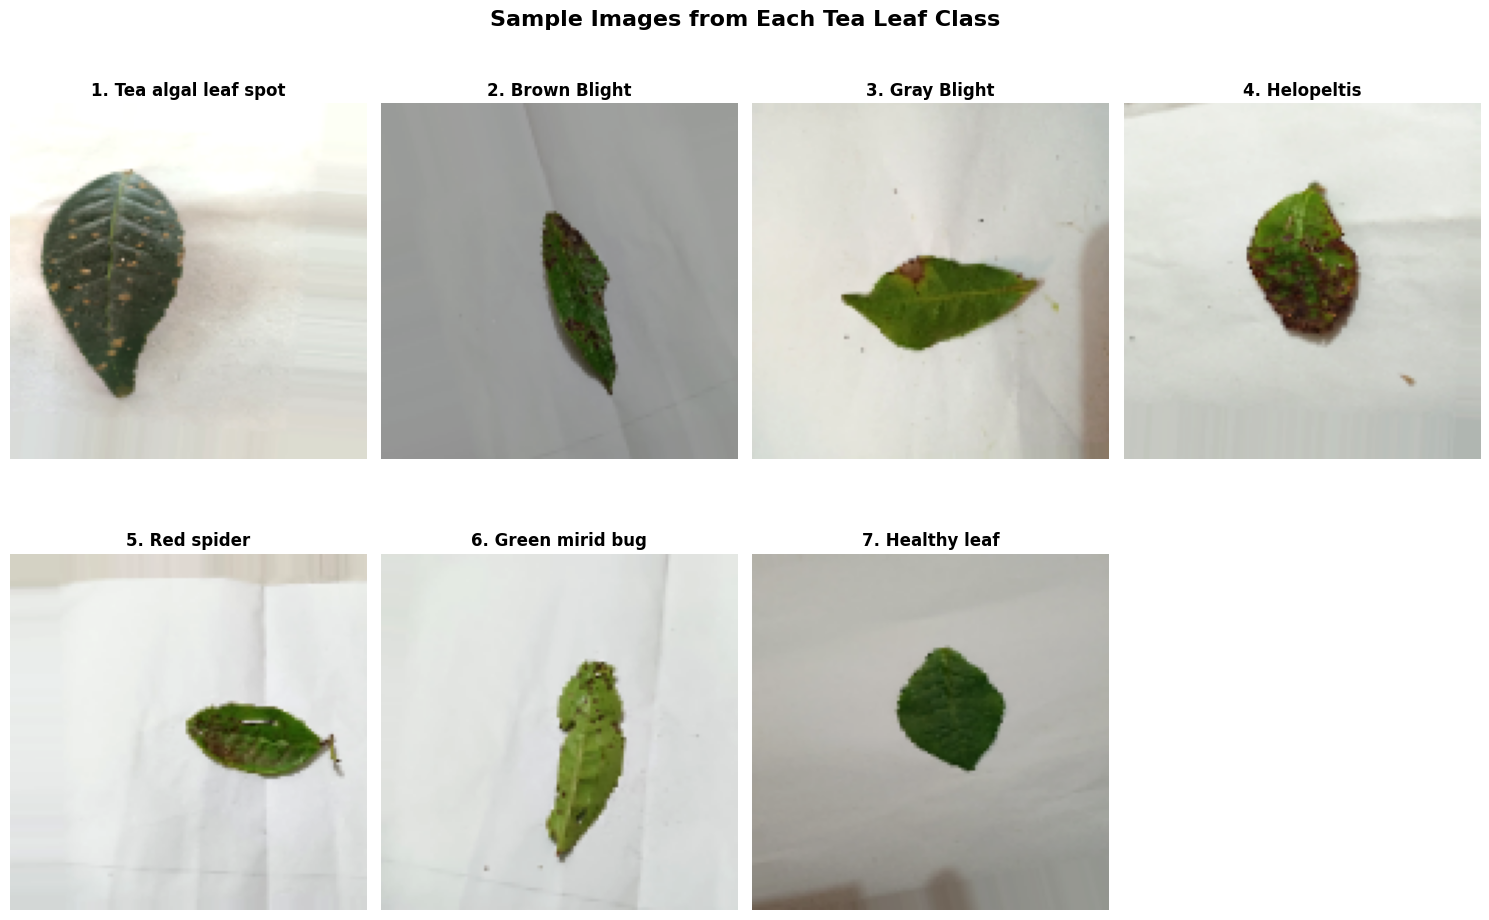

In [26]:
# Step 4: Explore Dataset with Analysis

# Print class labels mapping
print("\n✅ Class Labels Mapping:")
for class_name, idx in train_data.class_indices.items():
    print(f"   {idx} → {class_name}")

# Analyze class distribution for balanced training
def analyze_class_distribution():
    class_names = list(train_data.class_indices.keys())
    print(f"\n📊 Dataset Analysis:")
    print(f"🔹 Total Training Samples: {train_data.samples}")
    print(f"🔹 Total Validation Samples: {val_data.samples}")
    print(f"🔹 Samples per class (approx): {train_data.samples // len(class_names)}")

analyze_class_distribution()

# Show sample images from each class
class_names = list(train_data.class_indices.keys())
plt.figure(figsize=(15, 10))

# Get one batch of images
images, labels = next(train_data)

# Display samples from each class
for i in range(min(len(class_names), 8)):  # Show up to 8 classes
    plt.subplot(2, 4, i+1)
    # Find first image of each class
    class_indices = np.where(np.argmax(labels, axis=1) == i)[0]
    if len(class_indices) > 0:
        idx = class_indices[0]
        plt.imshow(images[idx])
        plt.title(f"{class_names[i]}", fontsize=12, fontweight='bold')
    plt.axis("off")

plt.suptitle("Sample Images from Each Tea Leaf Class", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [29]:
# Step 5: Build Enhanced CNN Model for Higher Accuracy

def create_improved_cnn_model(num_classes):
    model = models.Sequential([
        # Block 1 - Feature extraction
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128,128,3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.25),

        # Block 2 - Deeper features
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.3),

        # Block 3 - Complex patterns
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.4),

        # Block 4 - High-level features
        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),  # Better than flatten + maxpool
        layers.Dropout(0.5),

        # Dense layers for classification
        layers.Dense(512, activation='relu'),     # Increased neurons
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),     # Additional layer
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Create the improved model
num_classes = train_data.num_classes
model = create_improved_cnn_model(num_classes)

# Compile with CORRECTED metrics
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']  # Removed the problematic top_3_accuracy
)

# Display model architecture
model.summary()
print(f"\n🧠 Model created with {num_classes} output classes")

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,443,879 (5.51 MB)

 Trainable params: 1,440,423 (5.49 MB)

 Non-trainable params: 3,456 (13.50 KB)


🧠 Model created with 7 output classes


In [30]:
# Step 6: Train with Enhanced Configuration for Better Accuracy

# Improved callbacks for optimal training
early_stop = EarlyStopping(
    monitor='val_accuracy',        # Monitor accuracy instead of loss
    patience=10,                   # More patience for better convergence
    restore_best_weights=True,
    mode='max',                    # Maximize accuracy
    verbose=1
)

checkpoint = ModelCheckpoint(
    "best_tea_leaf_model.keras",   # Better naming
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,                    # More aggressive LR reduction
    patience=5,                    # Faster LR reduction
    min_lr=1e-7,
    verbose=1
)

# Train the model with enhanced settings
print("🚀 Starting Enhanced Training...")
print("⏱️  This may take 30-60 minutes depending on your dataset size")

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,                     # More epochs for better learning
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

print("\n✅ Training finished! Best model saved as 'best_tea_leaf_model.keras'")

🚀 Starting Enhanced Training...
⏱️  This may take 30-60 minutes depending on your dataset size
Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1799 - loss: 2.5932
Epoch 1: val_accuracy improved from -inf to 0.11491, saving model to best_tea_leaf_model.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 986s 7s/step - accuracy: 0.1802 - loss: 2.5915 - val_accuracy: 0.1149 - val_loss: 4.7393 - learning_rate: 0.0010
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3319 - loss: 1.8952
Epoch 2: val_accuracy did not improve from 0.11491
132/132 ━━━━━━━━━━━━━━━━━━━━ 1030s 8s/step - accuracy: 0.3319 - loss: 1.8949 - val_accuracy: 0.0902 - val_loss: 3.4210 - learning_rate: 0.0010
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3761 - loss: 1.6972
Epoch 3: val_accuracy improved from 0.11491 to 0.22127, saving model to best_tea_leaf_model.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 994s 8s/step - accuracy: 0.3761 - loss: 1.6971 - val_accuracy: 0.2213 - val_loss: 2.7287 - l

KeyboardInterrupt: 

In [31]:
# Step 7: Comprehensive Model Evaluation

# Load the best model
print("📈 Loading best model for evaluation...")
best_model = tf.keras.models.load_model("best_tea_leaf_model.keras")

# Evaluate on validation set
print("\n🎯 Final Model Performance:")
val_loss, val_accuracy = best_model.evaluate(val_data, verbose=1)
print(f"🏆 Final Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

# Calculate top-3 accuracy manually if needed
def calculate_top3_accuracy(model, data_generator):
    correct_top3 = 0
    total_samples = 0

    for batch_x, batch_y in data_generator:
        predictions = model.predict(batch_x, verbose=0)

        for i in range(len(batch_y)):
            true_class = np.argmax(batch_y[i])
            top3_predictions = np.argsort(predictions[i])[-3:]  # Get top 3

            if true_class in top3_predictions:
                correct_top3 += 1
            total_samples += 1

    return correct_top3 / total_samples

# Calculate top-3 accuracy (optional)
print("🔄 Calculating Top-3 Accuracy...")
top3_acc = calculate_top3_accuracy(best_model, val_data)
print(f"🥉 Top-3 Accuracy: {top3_acc:.4f} ({top3_acc*100:.2f}%)")

# Check if target accuracy achieved
if val_accuracy >= 0.80:
    print(f"🎉 SUCCESS! Achieved target accuracy of 80%+")
else:
    print(f"📊 Current accuracy: {val_accuracy*100:.1f}%. Consider fine-tuning for 80%+")

# Plot training history (simplified version)
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy Progress', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])

    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss Progress', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.suptitle(f'Tea Leaf Classification Training Results\nFinal Accuracy: {val_accuracy*100:.2f}%',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Display training results
plot_training_history(history)

# Performance summary
print("\n📋 Training Summary:")
print(f"🔹 Total Epochs Trained: {len(history.history['accuracy'])}")
print(f"🔹 Best Training Accuracy: {max(history.history['accuracy']):.4f}")
print(f"🔹 Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")

print("\n🎯 Results:")
if val_accuracy >= 0.80:
    print("✅ Model is ready for deployment!")
    print("✅ Consider testing on new tea leaf images")
else:
    print("📈 Consider transfer learning with pre-trained models")
    print("📈 Try increasing image resolution to 224x224")
    print("📈 Collect more training data if possible")

📈 Loading best model for evaluation...

🎯 Final Model Performance:
33/33 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.5714 - loss: 1.3087
🏆 Final Validation Accuracy: 0.5708 (57.08%)
🔄 Calculating Top-3 Accuracy...


KeyboardInterrupt: 